# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/My Drive/Colab Notebooks/CV"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Colab Notebooks/CV" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/Colab Notebooks/CV


# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1: # 90 degrees rotation
        return img.transpose(1, 2).flip(1)
    elif rot == 2: # 180 degrees rotation
        return img.flip(1).flip(2)
    elif rot == 3: # 270 degrees rotation
        return img.transpose(1, 2).flip(2)

    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

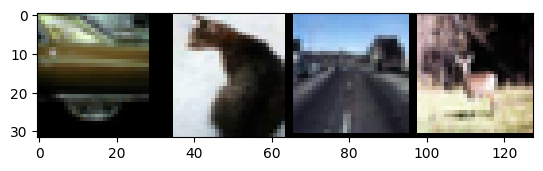

Class labels:  car   cat   truck deer 


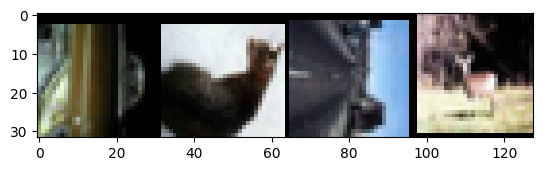

Rotation labels:  90    270   270   0    


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [22]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction

            outputs = net(images)

            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [23]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [26]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
#
#
#
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [27]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = None
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.

        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [28]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
#
torch.save(net.state_dict(), 'final_project_1.pth')

[1,   100] loss: 1.348 acc: 40.62 time: 8.45
[1,   200] loss: 1.190 acc: 48.07 time: 6.45
[1,   300] loss: 1.152 acc: 49.62 time: 8.09
TESTING:
Accuracy of the network on the 10000 test images: 54.01 %
Average loss on the 10000 test images: 1.065
[2,   100] loss: 1.096 acc: 52.49 time: 9.25
[2,   200] loss: 1.084 acc: 53.52 time: 7.07
[2,   300] loss: 1.068 acc: 54.55 time: 7.55
TESTING:
Accuracy of the network on the 10000 test images: 57.67 %
Average loss on the 10000 test images: 1.029
[3,   100] loss: 1.026 acc: 56.95 time: 6.64
[3,   200] loss: 1.020 acc: 56.69 time: 8.16
[3,   300] loss: 1.000 acc: 57.87 time: 6.57
TESTING:
Accuracy of the network on the 10000 test images: 60.90 %
Average loss on the 10000 test images: 0.960
[4,   100] loss: 0.990 acc: 58.78 time: 7.25
[4,   200] loss: 0.976 acc: 58.86 time: 9.36
[4,   300] loss: 0.961 acc: 59.73 time: 8.11
TESTING:
Accuracy of the network on the 10000 test images: 62.01 %
Average loss on the 10000 test images: 0.915
[5,   100] l

## Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model

# Randomly initialize a ResNet18 model
net = resnet18(num_classes=4)

# Load the pre-trained model from the local directory
pretrained_path = 'final_project_1.pth'
net.load_state_dict(torch.load(pretrained_path))

# Modify the final fully connected layer to match the number of CIFAR-10 classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False



In [31]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [32]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [33]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_2_rotation.pth')

[1,   100] loss: 1.712 acc: 37.96 time: 6.68
[1,   200] loss: 1.466 acc: 46.84 time: 6.78
[1,   300] loss: 1.404 acc: 49.62 time: 6.77
TESTING:
Accuracy of the network on the 10000 test images: 52.84 %
Average loss on the 10000 test images: 1.336
[2,   100] loss: 1.333 acc: 51.81 time: 6.10
[2,   200] loss: 1.319 acc: 53.30 time: 7.50
[2,   300] loss: 1.293 acc: 52.96 time: 6.30
TESTING:
Accuracy of the network on the 10000 test images: 53.97 %
Average loss on the 10000 test images: 1.304
[3,   100] loss: 1.288 acc: 53.47 time: 7.69
[3,   200] loss: 1.267 acc: 54.86 time: 7.87
[3,   300] loss: 1.251 acc: 54.91 time: 6.08
TESTING:
Accuracy of the network on the 10000 test images: 57.78 %
Average loss on the 10000 test images: 1.174
[4,   100] loss: 1.221 acc: 56.11 time: 6.93
[4,   200] loss: 1.213 acc: 56.45 time: 7.13
[4,   300] loss: 1.228 acc: 55.87 time: 6.16
TESTING:
Accuracy of the network on the 10000 test images: 57.42 %
Average loss on the 10000 test images: 1.215
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [34]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes=10)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in net.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False



In [36]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [38]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

In [39]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_2_random.pth')

[1,   100] loss: 2.122 acc: 24.62 time: 6.03
[1,   200] loss: 2.000 acc: 27.91 time: 7.71
[1,   300] loss: 1.926 acc: 30.71 time: 5.84
TESTING:
Accuracy of the network on the 10000 test images: 34.80 %
Average loss on the 10000 test images: 1.794
[2,   100] loss: 1.865 acc: 32.77 time: 6.12
[2,   200] loss: 1.842 acc: 33.57 time: 7.72
[2,   300] loss: 1.851 acc: 33.67 time: 5.91
TESTING:
Accuracy of the network on the 10000 test images: 36.50 %
Average loss on the 10000 test images: 1.755
[3,   100] loss: 1.821 acc: 33.84 time: 6.49
[3,   200] loss: 1.816 acc: 34.88 time: 7.48
[3,   300] loss: 1.801 acc: 35.56 time: 6.03
TESTING:
Accuracy of the network on the 10000 test images: 37.29 %
Average loss on the 10000 test images: 1.751
[4,   100] loss: 1.789 acc: 35.81 time: 10.28
[4,   200] loss: 1.773 acc: 35.80 time: 6.07
[4,   300] loss: 1.780 acc: 35.76 time: 7.57
TESTING:
Accuracy of the network on the 10000 test images: 38.50 %
Average loss on the 10000 test images: 1.727
[5,   100] 

## Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [40]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
# Randomly initialize a ResNet18 model
net = resnet18(num_classes=4)

# Load the pre-trained model from the local directory
pretrained_path = 'final_project_1.pth'
net.load_state_dict(torch.load(pretrained_path))

# Modify the final fully connected layer to match the number of CIFAR-10 classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
# TODO: Define criterion and optimizer
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [43]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_3_rotation.pth')

[1,   100] loss: 1.576 acc: 43.12 time: 6.59
[1,   200] loss: 1.312 acc: 53.29 time: 8.19
[1,   300] loss: 1.205 acc: 56.55 time: 6.46
TESTING:
Accuracy of the network on the 10000 test images: 62.80 %
Average loss on the 10000 test images: 1.074
[2,   100] loss: 1.088 acc: 61.52 time: 7.80
[2,   200] loss: 1.055 acc: 62.93 time: 6.92
[2,   300] loss: 1.010 acc: 64.50 time: 7.48
TESTING:
Accuracy of the network on the 10000 test images: 66.66 %
Average loss on the 10000 test images: 0.949
[3,   100] loss: 0.960 acc: 65.66 time: 8.33
[3,   200] loss: 0.937 acc: 66.85 time: 6.47
[3,   300] loss: 0.929 acc: 67.18 time: 8.31
TESTING:
Accuracy of the network on the 10000 test images: 67.72 %
Average loss on the 10000 test images: 0.924
[4,   100] loss: 0.872 acc: 69.16 time: 8.36
[4,   200] loss: 0.890 acc: 69.05 time: 7.48
[4,   300] loss: 0.856 acc: 70.55 time: 7.28
TESTING:
Accuracy of the network on the 10000 test images: 71.12 %
Average loss on the 10000 test images: 0.830
[5,   100] l

## Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [44]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes = 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
# TODO: Define criterion and optimizer
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [46]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_3_random.pth')

[1,   100] loss: 1.991 acc: 28.33 time: 7.07
[1,   200] loss: 1.687 acc: 38.64 time: 7.82
[1,   300] loss: 1.552 acc: 42.95 time: 6.97
TESTING:
Accuracy of the network on the 10000 test images: 49.63 %
Average loss on the 10000 test images: 1.400
[2,   100] loss: 1.426 acc: 49.07 time: 8.37
[2,   200] loss: 1.346 acc: 51.16 time: 6.60
[2,   300] loss: 1.311 acc: 52.69 time: 8.30
TESTING:
Accuracy of the network on the 10000 test images: 57.03 %
Average loss on the 10000 test images: 1.206
[3,   100] loss: 1.209 acc: 57.20 time: 8.31
[3,   200] loss: 1.176 acc: 58.12 time: 9.28
[3,   300] loss: 1.146 acc: 59.45 time: 6.74
TESTING:
Accuracy of the network on the 10000 test images: 61.11 %
Average loss on the 10000 test images: 1.099
[4,   100] loss: 1.071 acc: 61.86 time: 6.61
[4,   200] loss: 1.039 acc: 63.17 time: 8.15
[4,   300] loss: 1.025 acc: 64.16 time: 8.40
TESTING:
Accuracy of the network on the 10000 test images: 66.22 %
Average loss on the 10000 test images: 0.946
[5,   100] l